In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob # library for loading images from a directory
import cv2
from sklearn.model_selection import train_test_split 


## Image helper functions

In [2]:

def get_image_data(image_id, image_type):
    img = _get_image_data_opencv(image_id, image_type)
    img = img.astype('uint8')
    return img

def get_image_data_opencv(fname):
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s" % (fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def get_lightness_channel_from_image(image):
    HLS_img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    lightness_channel = HLS_img[:,:,1]
    return lightness_channel

def calculate_image_average(image):
    avr =cv2.mean(image)[0]
    return avr

# Data Visulization and Analysis

### Loading The Dataset

In [3]:
from pathlib import Path


direc = Path('../input/day-time-and-night-time-road-images/')
filepaths = list(direc.glob(r'**/*.jpg'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)

img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,../input/day-time-and-night-time-road-images/n...,night time road images
1,../input/day-time-and-night-time-road-images/n...,night time road images
2,../input/day-time-and-night-time-road-images/n...,night time road images
3,../input/day-time-and-night-time-road-images/d...,day light road images
4,../input/day-time-and-night-time-road-images/n...,night time road images


### Visualize the dataset

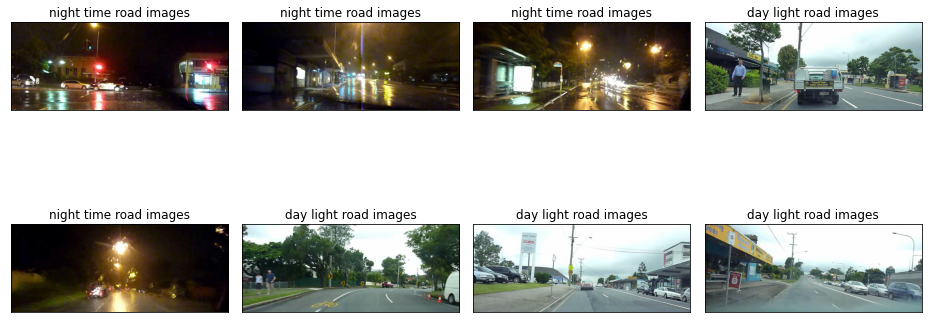

In [4]:
import matplotlib.pyplot as plt

f,a = plt.subplots(nrows=2, ncols=4, figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

### Data Analysis
* checking number of images and classes
* Checking each class data size


In [5]:
print(f" Total number of images : {img_df.shape[0]} \n classes number : {img_df.shape[1]} ")

 Total number of images : 31567 
 classes number : 2 


In [6]:
img_df['Labels'].value_counts(ascending=True)

day light road images     14607
night time road images    16960
Name: Labels, dtype: int64

# Splitting the dataset into train,test

In [7]:
train_ratio = 0.75
test_ratio = 0.25

x_train, x_test = train_test_split(img_df, test_size= 1 - train_ratio)

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)

Shape of Training Data :  (23675, 2)
Shape of Testing Data :  (7892, 2)


# Model Creating (Based on image processing techniques)

### Visualizing Ligthness in Images 
We will see that high values represent in day time images (high lightnening) 

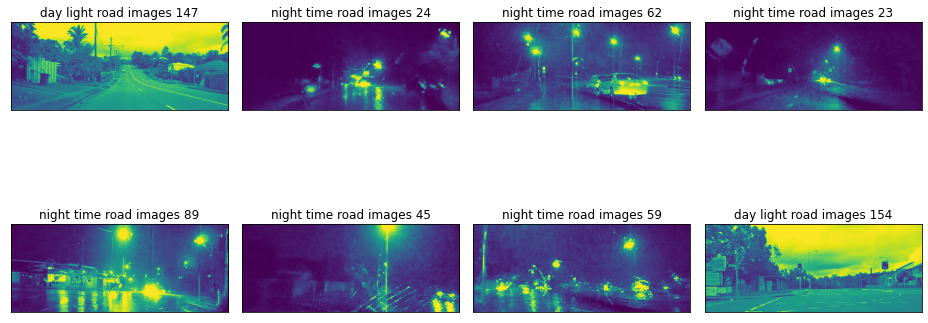

In [8]:
nrows = 2
ncols = 4
f,a = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

x_train_sample = x_train.sample(n=nrows*ncols)

for i, ax in zip(x_train_sample.index,a.flat):
    BGR_img = get_image_data_opencv(x_train_sample.FilePaths[i])
    light_img =get_lightness_channel_from_image(BGR_img)
    average = calculate_image_average (light_img)
    ax.imshow(light_img)
    ax.set_title(img_df.Labels[i]+" "+str(round(average)))
    
plt.tight_layout()
plt.show()

# The classical easy classifier
From checking the average of the images lightness channel values, we saw that day time images averages are leger than 100 and the night images are low in light average 

In [9]:
classes = ["night time road images","day light road images"]

In [10]:
def Classify(data_sample,threshold=100):
    BGR_img = get_image_data_opencv(data_sample.FilePaths)
    light_img =get_lightness_channel_from_image(BGR_img)
    average = calculate_image_average (light_img)
    
    output = 0
    if average > threshold:
        output = 1
    
    #if classes[output] != row.Labels:
     #   print("ground truth : ",data_sample.Labels," ",str(round(average)), "Prediction : "\
      #       , str(classes[output]))
      #  plt.imshow(light_img)
      #  plt.show()
    
    return output
    

## Check accuracy

In [11]:
T = 0
F = 0


for index, row in x_test.iterrows():

    output = Classify(row,threshold=100)
    if classes[output] == row.Labels:
        T += 1
    else :
        F += 1
        
print("Right classification =",T," False classification =",F, " ACCURACY = ",T/(T+F))
        


Right classification = 7756  False classification = 136  ACCURACY =  0.9827673593512417
